In [15]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 

import sklearn
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


Input dimensions: 784


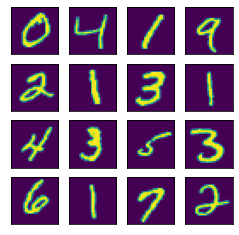

In [16]:
(x_train, _), (x_test, y_test) = mnist.load_data()
n = 4

# Normalize pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print("Input dimensions:", x_train[0].size)

plt.figure(figsize=(4, 4))

# Plot 4x4 grid of training samples
for i in range(1, n*n+1):
    ax = plt.subplot(n, n, i)
    plt.imshow(x_train[i])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


Sparse constraint

Forcing a layer's average activation to be close to a constraint

Why do we want to do this?
Try to get the network to not learn the principal components of the data?
Get the weights to fire less?




In [17]:
# Define autoencoder

latent_dim = 32

class Autoencoder(Model):
    # Constructor
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            # Converts tensor input to vector? (28, 28) -> (784)
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
        ])
        self.decoder = tf.keras.Sequential([
            # Output 784 pixel values between [0, 1]
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28)),
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [18]:
# "Configures the model for training", we specify loss, metrics, etc.

# Binary cross entropy cause pixel values are [0, 1]?
autoencoder.compile(optimizer='adam', loss = losses.BinaryCrossentropy())

In [5]:
# Training
# epochs: nr passes over the dataset
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

235/235 [==============================] - 2s 7ms/step - loss: 0.1060 - val_loss: 0.1045
Epoch 14/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1054 - val_loss: 0.1040
Epoch 15/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1049 - val_loss: 0.1035
Epoch 16/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1044 - val_loss: 0.1030
Epoch 17/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1040 - val_loss: 0.1027
Epoch 18/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1037 - val_loss: 0.1024
Epoch 19/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1033 - val_loss: 0.1021
Epoch 20/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1030 - val_loss: 0.1017
Epoch 21/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1028 - val_loss: 0.1015
Epoch 22/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1025 - val_loss: 0.1012
Ep

In [6]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32)                25120     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


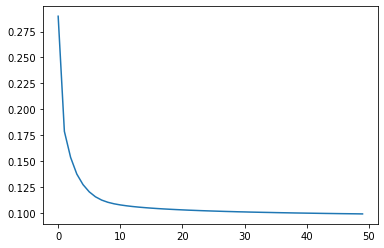

In [7]:
plt.plot(history.history['loss'])
plt.show()

In [8]:
# Evaluate of test set
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape)
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

(10000, 32)


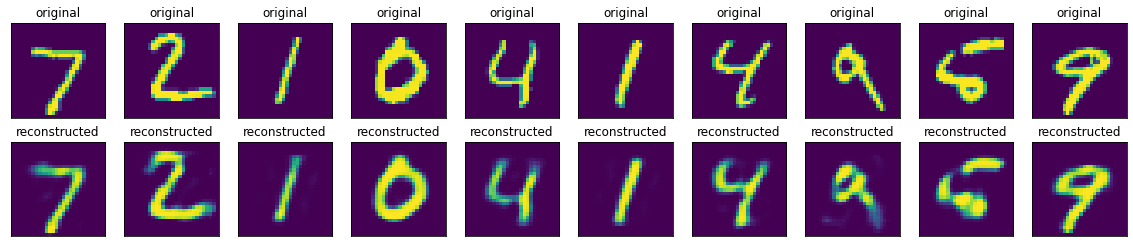

In [9]:
n = 10
plt.figure(figsize=(20, 4)) # Specifies window width / height
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [10]:
# linear interpolation test
img_1 = x_test[2].reshape(1, x_test[0].size) # resize to single element tensor
img_2 = x_test[3].reshape(1, x_test[1].size)

# image encodings
encoded_img_1 = autoencoder.encoder(img_1).numpy() 
encoded_img_2 = autoencoder.encoder(img_2).numpy()
nbr_points = 12

t = np.linspace(1, 0, num=nbr_points)

encoded_interpols = np.zeros([nbr_points, encoded_img_1.size])

for i in range(nbr_points):
    encoded_interpols[i] = t[i] * encoded_img_1 + (1-t[i]) * encoded_img_2

print(encoded_interpols.shape)

decoded_interpols = autoencoder.decoder(encoded_interpols).numpy()

(12, 32)


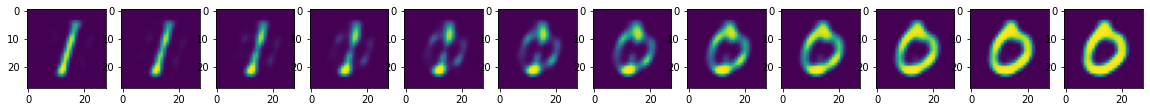

In [11]:
# Plot interpolations

plt.figure(figsize=(20, 4))
for i in range(nbr_points):
    ax = plt.subplot(1, nbr_points, i+1)
    plt.imshow(decoded_interpols[i])

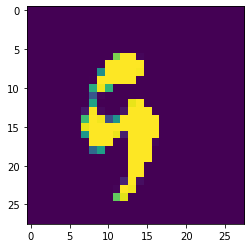

In [12]:
random_latent = np.random.rand(latent_dim)*37
random_latent = random_latent.reshape(1, latent_dim)
random_decoded = autoencoder.decoder(random_latent)

plt.figure()
plt.imshow(random_decoded.numpy()[0])


In [13]:
# T-SNE test

from sklearn.manifold import TSNE

embeddings_tsne = TSNE(n_components=2).fit_transform(encoded_imgs)
interpols_tsne = TSNE(n_components=2).fit_transform(encoded_interpols)

print(embeddings_tsne.shape)

(10000, 2)


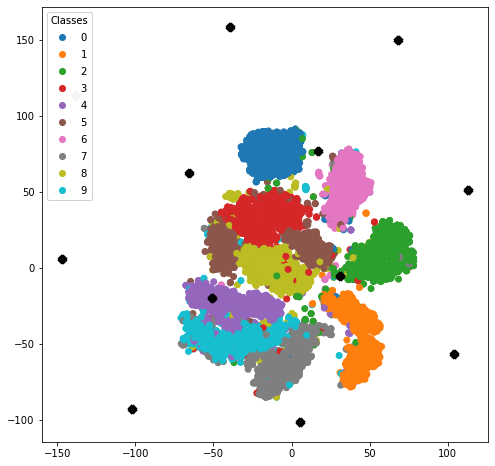

In [19]:
# Plot projected embeddings
fig, ax = plt.subplots(figsize=(8,8))

scatter = ax.scatter(embeddings_tsne[:,0], embeddings_tsne[:,1], c = y_test.astype('float32'), cmap='tab10')

# Plot interpolated points, weird structure caused by TSNE?
ax.scatter(interpols_tsne[:,0], interpols_tsne[:,1], marker="x", color='000000', linewidths=6)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")

ax.add_artist(legend1)

plt.show()